# 神经网络和机器学习之手势识别

案例描述：石头剪刀布（手势识别，卷积神经网络，CNN）

本案例利用卷积神经网络（CNN）来识别“石头剪刀布”手势。数据集（手势图片）来自网络，分为石头、剪刀、布三种手势，用于训练数据集中每一种手势有841张，测试的有125张。每一张图片已经处理为`128*128`像素，三个通道。从难度看，这个案例并没有比前两个复杂（手写体数字识别和CIFAR-10图片分类），但接近生活，尤其适合用在虚谷号上。利用USB摄像头，虚谷号就可以识别用户的手势。

案例选择了keras框架，需要先安装keras和tensorflow。虚谷号教育版已经预装必要的库，可以直接使用。因为这个数据集很大，在虚谷号上训练比较慢，建议在电脑上训练。

本案例已经提供了训练好的模型，放在model文件夹中，文件名称为：5-model-vv.h5。如果想直接测试模型，请跳到“应用模型”环节，拍摄或者上传图片开始识别。

## 1.环境搭建

下面是安装命令：

pip install keras

pip install -i https://pypi.tuna.tsinghua.edu.cn/simple tensorflow

建议选择清华源，速度将快很多。参考命令如下：

pip install -i https://pypi.tuna.tsinghua.edu.cn/simple tensorflow

## 2.数据准备

数据集来源：http://www.laurencemoroney.com/rock-paper-scissors-dataset/

下载解压后，发现是按照文件夹分类存储的“石头剪刀布”的图片，分为三个文件夹，分别用于训练（rps）、验证（rps-test-set）和交叉验证（rps-validation）。rps和rps-test-set文件夹中都已经分成了三类，'rock'为石头，'scissors'是剪刀，'paper'是布。为了让数据集更小一点，我用Python写了一个脚本，批量将每一张图片处理为`128 * 128`像素。

已经处理好的数据集可以通过Github下载，在“课程汇集/虚谷号内置课程目录/5.机器学习”中，文件名为“hand.tar”，约40M。

- Github：https://github.com/vvlink/vvBoard-docs
- 码云镜像：https://gitee.com/xiezuoru/vvBoard-docs

如果用虚谷号进行训练，请上传hand.tar到data文件夹下，然后用tar命令解压。参考命令：

    cd ~/Jupyter/vvBoardBook/5.机器学习/data

    tar -xf hand.tar

这次使用的数据集没有提供标签数据，需要自己写程序来整理。我先写一个遍历文件夹的函数。

In [1]:
#遍历文件夹中图片的函数
import os
image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
def list_images(basePath, contains=None):
    # 返回有效的图片路径数据集
    return list_files(basePath, validExts=image_types, contains=contains)
def list_files(basePath, validExts=None, contains=None):
    # 遍历图片数据目录，生成每张图片的路径
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # 循环遍历当前目录中的文件名
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            # 无意中发现mac处理的文件夹会生成“._”开头的文件，于是过滤
            if contains is not None and filename.find(contains) == -1 or filename[0:2]=='._':
                continue
            # 通过确定.的位置，从而确定当前文件的文件扩展名
            ext = filename[filename.rfind("."):].lower()
            # 检查文件是否为图像，是否应进行处理
            if validExts is None or ext.endswith(validExts):
                # 构造图像路径
                imagePath = os.path.join(rootDir, filename)
                yield imagePath

In [2]:
#定义标签对应的数字，石头为0，剪刀为1，布为2
label_num=["rock","scissors","paper"]
#得到训练文件夹中的图片文件列表
rps_Paths = sorted(list(list_images('./data/hand/rps/')))
#得到验证文件夹中的图片文件列表
test_Paths = sorted(list(list_images('./data/hand/rps-test-set/')))

得到图片文件的列表后，批量用`keras.preprocessing`的`load_img`读入，然后同步根据文件夹名称在label_num中得到标签值。具体的介绍可以参考前面的几个案例。

In [3]:
from keras.preprocessing import image
import numpy as np
# 生成训练集数据
rps_data = []
rps_labels = []
for imagePath in rps_Paths:
    r_img = image.load_img(imagePath,target_size=(32, 32))
    r_img = image.img_to_array(r_img,dtype="uint8")
    rps_data.append(r_img)
    # 读取标签，并且用0，1，2来编码
    #(在“./dataset/rps-test-set/paper/testpaper01-00.png”中取出“paper”)
    t = imagePath.split(os.path.sep)[-2]
    # 将“paper”之类的单词转换为0，1，2
    rps_labels.append(label_num.index(t))
rps_data = np.array(rps_data)
rps_labels = np.array(rps_labels)
# 生成验证集数据
test_data = []
test_labels = []
for imagePath in test_Paths:
    r_img = image.load_img(imagePath,target_size=(32, 32))
    r_img = image.img_to_array(r_img,dtype="uint8")
    test_data.append(r_img)
    t = imagePath.split(os.path.sep)[-2]
    test_labels.append(label_num.index(t))
test_data = np.array(test_data)
test_labels = np.array(test_labels)

Using TensorFlow backend.


数据读出后，放在了rps_data、rps_labels和test_data、test_labels四个数组中。可以读出几个试试，看看图像和标签是否一致。

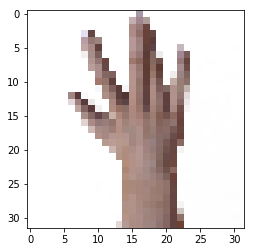

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(rps_data[2])

In [5]:
# 输出对应的标签值
print(rps_labels[2])

2


In [6]:
# 查看数据集的形状，维度是不是4，长度是2520，即有2520张图片
print(rps_data.shape)

(2520, 32, 32, 3)


## 3.搭建模型

通过以下代码建立卷积神经网络模型并进行编译。注意几个关键点：

- 第一层要设置输入图片的尺寸和颜色通道，“32,32,3”。前面为了训练速度快一点，读入的图片为`32*32`；
- 最后一层，神经元的数量为3，因为只有3个类别。

In [7]:
import keras
from keras import layers
from keras import datasets
model=keras.models.Sequential()
model.add(layers.Conv2D(64,(3,3),activation='relu',input_shape=(32,32,3)))  #第一层要设置输入图片的尺寸和颜色通道
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D())
model.add(layers.Flatten()) #在全连接之前，需要将二维图片数据转换成一维数组
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.5))  #为了防止过拟合，Dropout层会随机的丢弃一部分神经网络连接
model.add(layers.Dense(3,activation='softmax'))  #使用softmax处理多分类问题，一共3个类别

In [8]:
#在训练过程中打印出准确率（acc）指标
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc']) 

## 4.训练模型

开始训练吧。rps_data、rps_labels和test_data、test_labels，这四个数组要对号入座。

在虚谷号上batch_size要设置小一点，比如200。实测batch_size设置大于600，jupyter服务将挂起。如果是电脑上，可以设置为1000或者更大一点，但不要超过总样本数（2520）的一半，训练的速度快一点。

In [30]:
model.fit(x=rps_data,y=rps_labels,batch_size=200,epochs=5,validation_data=(test_data,test_labels))

Train on 2520 samples, validate on 372 samples
Epoch 1/5
2520/2520 [==============================] - 96s 38ms/step - loss: 0.0099 - acc: 0.9972 - val_loss: 1.1102 - val_acc: 0.7930
Epoch 2/5
2520/2520 [==============================] - 95s 38ms/step - loss: 0.0048 - acc: 0.9988 - val_loss: 0.9041 - val_acc: 0.7903
Epoch 3/5
2520/2520 [==============================] - 95s 38ms/step - loss: 0.0042 - acc: 0.9996 - val_loss: 1.3518 - val_acc: 0.8038
Epoch 4/5
2520/2520 [==============================] - 95s 38ms/step - loss: 9.8764e-04 - acc: 1.0000 - val_loss: 1.3131 - val_acc: 0.7769
Epoch 5/5
2520/2520 [==============================] - 95s 38ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 1.2434 - val_acc: 0.7903


batch_size设置为200的情况下，前三轮loss一直处于10左右，第四轮开始，loss快速下降。10个轮次后，就loss就到了0.01以下。每一轮次需要95秒，还是能够接受的。

## 5.测试模型

再利用模型来识别rps-validation中图片的内容，可以看到图片中的手写数字被成功的识别了出来。

In [31]:
#得到测试的图片所有的文件列表
from keras.preprocessing import image
import numpy as np
imagePaths = sorted(list(list_images('./data/hand/rps-validation')))
print("------开始读取要识别的图片------")
i_data = []
i_labels = []
for imagePath in imagePaths:
    r_img = image.load_img(imagePath,target_size=(32, 32))
    r_img = image.img_to_array(r_img,dtype="uint8")
    i_data.append(r_img)
    #记录文件名称，对应输出
    label = imagePath.split(os.path.sep)[-1]
    i_labels.append(label)
i_data = np.array(i_data) 

------开始读取要识别的图片------


识别并且输出文件名和识别结果。如果不够准确，就再训练一次。一般来说，loss小于0.1，识别效果就不错了。这么多图片，就2张识别失败了，还不错吧。

In [32]:
t=model.predict_classes(i_data)
for i in range(len(t)):
    print(t[i],end=' ') 
    print(i_labels[i])

2 paper-hires1.png
2 paper-hires2.png
2 paper1.png
2 paper2.png
2 paper3.png
2 paper4.png
2 paper5.png
2 paper6.png
2 paper7.png
2 paper8.png
0 paper9.png
0 rock-hires1.png
0 rock-hires2.png
1 rock1.png
0 rock2.png
0 rock3.png
0 rock4.png
0 rock5.png
0 rock6.png
0 rock7.png
0 rock8.png
0 rock9.png
1 scissors-hires1.png
1 scissors-hires2.png
1 scissors1.png
1 scissors2.png
1 scissors3.png
1 scissors4.png
1 scissors5.png
1 scissors6.png
1 scissors7.png
1 scissors8.png
1 scissors9.png


## 6.保存模型

训练出来的模型，可以保存。下次使用的时候载入，还可以继续训练。一般保存为h5格式，需要先安装h5py。

命令如下：pip install h5py

In [37]:
model.save('./model/5-model-hand.h5')   # HDF5文件

要继续训练或者应用模型，用这样的语句即可导入。如果遇到高版本训练的模型如果导入，加上`compile=False`的参数。

In [13]:
from keras.models import load_model  
model = load_model('./model/5-model-hand.h5',compile=False)

## 7.应用模型

用摄像头或者手机拍摄一张石头剪刀布的手势图。然后调用这个模型来识别，并输出结果。

先导入必要的库和模型。

In [14]:
from keras.preprocessing import image
import numpy as np
from keras.models import load_model
model = load_model('./model/5-model-hand.h5')

下面是利用虚谷号的摄像头拍摄图片的代码，没有摄像头请跳过，直接上传一张名为`test.jpg`的带手势的图片。

**注意：**摄像头要朝下拍摄手势，样子要和训练用的图片一致。

In [34]:
import cv2
#基本函数1：获取摄像头内容保存为图片
def getcampic(fname):
    cap = cv2.VideoCapture(0)        # 打开摄像头
    ret, frame = cap.read()       # 读摄像头
    cv2.imwrite(fname,frame)
    cap.release()      
    cv2.destroyAllWindows() 
    return True
##调用getcampic函数
getcampic("test.jpg")

True

执行上面程序后，虚谷号启动摄像头拍摄一张图片，这个目录下将增加一个名为`test.jpg`的图片。需要注意的是，背景最好也是白色的，和用于训练的图片一致。

In [35]:
label_name=["rock","scissors","paper"]
i_data=[]
r_img = image.load_img("./test.jpg",target_size=(32, 32))
r_img = image.img_to_array(r_img,dtype="uint8")
i_data.append(r_img)
i_data = np.array(i_data)
t=model.predict_classes(i_data)
#直接输出名称
print(label_name[t[0]])

rock


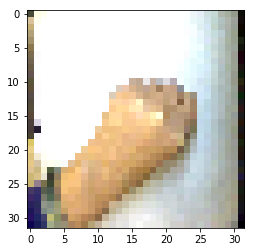

In [36]:
#看看是什么图
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(i_data[0])

学习记录：如果看不懂代码，请先了解numpy、opencv、keras等相关的库。